In [1]:
import sys
from omegaconf import OmegaConf
import torch
from torch.optim import lr_scheduler
import torch.nn as nn

from utils.train_utils import select_device, fix_seed, log_images, calculate_metrics_fromloader, pred_fn, image_float2int
from utils.builder import build_data, build_models, build_optimizer

/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = OmegaConf.load('./config/mae/vae_kaggle_oct_small.yaml')
gpus = select_device('0', configs.data.batch_size)

In [3]:
fix_seed(2023)

In [ ]:
checkpoint_path = '/raid/binod/prashant/eye2gene/logs/MAE_kaggle_oct_single/models/best.pth'
ckpt = torch.load(checkpoint_path)

In [4]:
train_loader, val_loader, test_loader = build_data(configs)

In [5]:
# set jupyter auto reload and 2
%load_ext autoreload
%autoreload 2


In [6]:
from models.res_vae import VAE
from tqdm import tqdm
#Create VAE network
device = 'cuda:0'
vae_net = VAE(channel_in=3, ch=64).to(device)
# setup optimizer
lr = 1e-4
optimizer = torch.optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
#Loss function
loss_log = []
nepoch = 100
start_epoch = 0


In [7]:
def kl_loss_fn(mu, logvar):
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

import torch.nn.functional as F
import wandb
# wandb login using api key
# !export WANDB_API_KEY=d8/6336fbe1e8b0ef444fa1f7f67208a1333b7176
print("logged in ")
# wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: pstha (eye2gene). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/binod/.netrc


logged in 


In [8]:
wandb.finish()

In [9]:
assert wandb.run is None

In [10]:
wandb.init(project="Eye2Gene", entity="pstha", name="res_VAE_kaggle_3")
print("init")

wandb: Currently logged in as: pstha. Use `wandb login --relogin` to force relogin


init


In [11]:
import torch.nn as nn
import torch


class VGG19(nn.Module):
    """
     Simplified version of the VGG19 "feature" block
     This module's only job is to return the "feature loss" for the inputs
    """

    def __init__(self, channel_in=3, width=64):
        super(VGG19, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, width, 3, 1, 1)
        self.conv2 = nn.Conv2d(width, width, 3, 1, 1)

        self.conv3 = nn.Conv2d(width, 2 * width, 3, 1, 1)
        self.conv4 = nn.Conv2d(2 * width, 2 * width, 3, 1, 1)

        self.conv5 = nn.Conv2d(2 * width, 4 * width, 3, 1, 1)
        self.conv6 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv7 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv8 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)

        self.conv9 = nn.Conv2d(4 * width, 8 * width, 3, 1, 1)
        self.conv10 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv11 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv12 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.conv13 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv14 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv15 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv16 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.load_params_()

    def load_params_(self):
        # Download and load Pytorch's pre-trained weights
        state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth')
        for ((name, source_param), target_param) in zip(state_dict.items(), self.parameters()):
            target_param.data = source_param.data
            target_param.requires_grad = False

    def feature_loss(self, x):
        return (x[:x.shape[0] // 2] - x[x.shape[0] // 2:]).pow(2).mean()

    def forward(self, x):
        """
        :param x: Expects x to be the target and source to concatenated on dimension 0
        :return: Feature loss
        """
        x = self.conv1(x)
        loss = self.feature_loss(x)
        x = self.conv2(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 64x64

        x = self.conv3(x)
        loss += self.feature_loss(x)
        x = self.conv4(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 32x32

        x = self.conv5(x)
        loss += self.feature_loss(x)
        x = self.conv6(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv7(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv8(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 16x16

        x = self.conv9(x)
        loss += self.feature_loss(x)
        x = self.conv10(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv11(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv12(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 8x8

        x = self.conv13(x)
        loss += self.feature_loss(x)
        x = self.conv14(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv15(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv16(self.relu(x))
        loss += self.feature_loss(x)

        return loss/16


In [12]:
feature_extractor = VGG19().to(device)

In [14]:
use_perception=True
# error = 0
loss_log = []
best_val_error = 10e7
for epoch in range(start_epoch, nepoch):
    vae_net.train()
    error = 0
    for i, batch in enumerate(train_loader):
        images = batch['image']
        images = images.to(device)

        recon_img, mu, logvar = vae_net(images)
        #VAE loss
        kl_loss = kl_loss_fn(mu, logvar)
        mse_loss = F.mse_loss(recon_img, images)
        
        #Perception loss
        if use_perception:
            feat_in = torch.cat((recon_img, images), 0)
            feature_loss = feature_extractor(feat_in)
        else:
            feature_loss = 0.0
        
        loss = kl_loss + mse_loss + feature_loss
    
        loss_log.append(loss.item())
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

        error += torch.linalg.norm(loss).item()
        # i += 1
        wandb.log({"loss": loss.item(), "mse_loss": mse_loss.item(), "kl_loss": kl_loss.item(), "feature_loss": feature_loss})
    print(f"Train error for epoch {epoch + 1}: {error / i}")
    

    # eval
    vae_net.eval()
    with torch.no_grad():
        val_error = 0
        for j, batch in enumerate(val_loader):
            images = batch["image"]
            images = images.to(device)
            recon_img, mu, logvar = vae_net(images)
            kl_loss = kl_loss_fn(mu, logvar)
            mse_loss = F.mse_loss(recon_img, images)

            if use_perception:
                feat_in = torch.cat((recon_img, images), 0)
                feature_loss = feature_extractor(feat_in)
            else:
                feature_loss = 0.0
            
            loss = kl_loss + mse_loss + feature_loss
            val_error += torch.linalg.norm(loss).item()
            wandb.log({"val_loss": loss.item(), "val_mse_loss": mse_loss.item(), "val_kl_loss": kl_loss.item(), "val_feature_loss": feature_loss})
        print(f"Val error for epoch {epoch + 1}: {val_error / j}")

        epoch_error = val_error / j
        if epoch_error < best_val_error:
            best_val_error = epoch_error
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(ckpt, f"/raid/binod/prashant/eye2gene/logs/VAE_best.pth")
        
        if epoch % 5 == 0:
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(ckpt, f"/raid/binod/prashant/eye2gene/logs/VAE_latest.pth")



    #In eval mode the model will use mu as the encoding instead of sampling from the distribution
    # vae_net.eval()
    # with torch.no_grad():
    #     recon_img, _, _ = vae_net(test_images.to(device))
    #     img_cat = torch.cat((recon_img.cpu(), test_images), 2)
        
    #     vutils.save_image(img_cat,
    #                       "%s/%s/%s_%d.png" % (save_dir, "Results" , model_name, image_size),
    #                       normalize=True)

    #     #Save a checkpoint
    #     torch.save({
    #                 'epoch'                         : epoch,
    #                 'loss_log'                      : loss_log,
    #                 'model_state_dict'              : vae_net.state_dict(),
    #                 'optimizer_state_dict'          : optimizer.state_dict()

    #                  }, save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt")  

Train error for epoch 1: 7.478894544883333
Val error for epoch 1: 4.756419475261982
Train error for epoch 2: 4.086132665970961
Val error for epoch 2: 3.4647101145524246
Train error for epoch 3: 3.3855424970674424
Val error for epoch 3: 3.0224673913075373
Train error for epoch 4: 3.362956300578053
Val error for epoch 4: 2.921672454247108
Train error for epoch 5: 2.835114371067274
Val error for epoch 5: 2.673114329117995
Train error for epoch 6: 2.6795289305945045
Val error for epoch 6: 2.6862798855854915
Train error for epoch 7: 2.5562756299514917
Val error for epoch 7: 2.4840517649283775
Train error for epoch 8: 2.465627277652499
Val error for epoch 8: 2.2571551102858325
Train error for epoch 9: 2.382724047622388
Val error for epoch 9: 2.2286323382304265
Train error for epoch 10: 2.3044602802298577
Val error for epoch 10: 2.198193107201503
Train error for epoch 11: 2.2499904563925774
Val error for epoch 11: 2.198251766424913
Train error for epoch 12: 2.1965774153564803
Val error for ep

KeyboardInterrupt: 

# --------------------------------different

In [7]:
from models.vae import *
# import tqdm for notebooks
from tqdm import tqdm

In [8]:
# writer = SummaryWriter()
def train_vae(model: nn.Module, data: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epochs = 10, device = 'cpu'):
    model.to(device)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        i = 0
        error = 0
        for batch in tqdm(data):
            inp = batch["image"]
            label = batch["label"]
            inp = inp.to(device)
            optimizer.zero_grad()
            output = model(inp)
            rc_loss = ((inp - output) ** 2).sum()/(64*64*3)
            loss = rc_loss + model.kl
            loss.backward()
            # print(model.kl, rc_loss)
            # exit()
            optimizer.step()
            error += torch.linalg.norm(loss).item()
            i += 1
        # writer.add_scalar("Loss/train", error / i, epoch + 1)
        print(f"Error for epoch {epoch + 1}: {error / i}")

    return model


In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dims = 2
model = VariationalAutoEncoder(code_size=latent_dims)
# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# model_path = "../models/vae_2.pth"
# model.load_state_dict(torch.load(model_path))
optimizer = torch.optim.Adam(model.parameters())
model = train_vae(model, train_loader, optimizer, device=device, epochs=40)

cuda:0


100%|██████████| 522/522 [01:24<00:00,  6.16it/s]


Error for epoch 1: 165.31939985194882


100%|██████████| 522/522 [01:08<00:00,  7.67it/s]


Error for epoch 2: 156.1909434585279


100%|██████████| 522/522 [01:43<00:00,  5.03it/s]


Error for epoch 3: 156.13455350737004


100%|██████████| 522/522 [01:46<00:00,  4.90it/s]


Error for epoch 4: 156.1748038397895


100%|██████████| 522/522 [01:49<00:00,  4.77it/s]


Error for epoch 5: 156.12417349687482


100%|██████████| 522/522 [01:52<00:00,  4.65it/s]


Error for epoch 6: 156.11831717655576


100%|██████████| 522/522 [01:44<00:00,  4.97it/s]


Error for epoch 7: 156.10966440544274


100%|██████████| 522/522 [01:39<00:00,  5.26it/s]


Error for epoch 8: 156.0871467444175


100%|██████████| 522/522 [01:42<00:00,  5.11it/s]


Error for epoch 9: 156.1014710641912


100%|██████████| 522/522 [01:38<00:00,  5.30it/s]


Error for epoch 10: 156.1086074712176


100%|██████████| 522/522 [01:29<00:00,  5.81it/s]


Error for epoch 11: 156.09060363477218


100%|██████████| 522/522 [01:11<00:00,  7.27it/s]


Error for epoch 12: 156.08962821229665


 18%|█▊        | 94/522 [00:16<01:15,  5.64it/s]


KeyboardInterrupt: 

In [6]:
model = build_models(configs, torch.cuda.is_available(), gpus)
model = model.float().cuda(gpus[0])

In [7]:
model.load_state_dict(ckpt['model'])
# optimizer = build_optimizer(configs, model)
# optimizer.load_state_dict(ckpt['optimizer'])
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, 
#                         T_0=configs.lr_warmup_epochs,
#                         T_mult=configs.lr_mult)
# scheduler.load_state_dict(ckpt['scheduler'])
configs.epoch = ckpt['epoch']

In [8]:
print(configs.epoch)

197


In [9]:
import matplotlib.pyplot as plt

In [43]:
images = pred_fn(model, val_loader, configs.model.patch_sz, 1)
# images.shape

In [44]:
images[0][1]

tensor([[[ 0.4431,  0.4431,  0.4431],
         [ 0.5373,  0.5373,  0.5373],
         [ 0.5765,  0.5765,  0.5765],
         ...,
         [-0.8902, -0.8902, -0.8902],
         [-0.8275, -0.8275, -0.8275],
         [-0.5922, -0.5922, -0.5922]],

        [[ 0.1216,  0.1216,  0.1216],
         [ 0.1765,  0.1765,  0.1765],
         [ 0.3412,  0.3412,  0.3412],
         ...,
         [-0.7490, -0.7490, -0.7490],
         [-0.9059, -0.9059, -0.9059],
         [-0.7176, -0.7176, -0.7176]],

        [[-0.0510, -0.0510, -0.0510],
         [-0.0431, -0.0431, -0.0431],
         [ 0.0824,  0.0824,  0.0824],
         ...,
         [-0.7490, -0.7490, -0.7490],
         [-0.8902, -0.8902, -0.8902],
         [-0.8353, -0.8353, -0.8353]],

        ...,

        [[-0.8902, -0.8902, -0.8902],
         [-0.8745, -0.8745, -0.8745],
         [-0.8902, -0.8902, -0.8902],
         ...,
         [-0.7725, -0.7725, -0.7725],
         [-0.7961, -0.7961, -0.7961],
         [-0.8431, -0.8431, -0.8431]],

        [[

In [46]:
images[0][29][0:40, 0:40]

tensor([[[-0.6941, -0.6941, -0.6941],
         [-0.7725, -0.7725, -0.7725],
         [-0.9216, -0.9216, -0.9216],
         ...,
         [-0.7725, -0.7725, -0.7725],
         [-0.8353, -0.8353, -0.8353],
         [-0.8196, -0.8196, -0.8196]],

        [[-0.7412, -0.7412, -0.7412],
         [-0.8275, -0.8275, -0.8275],
         [-0.6941, -0.6941, -0.6941],
         ...,
         [-0.7647, -0.7647, -0.7647],
         [-0.7020, -0.7020, -0.7020],
         [-0.7176, -0.7176, -0.7176]],

        [[-0.6941, -0.6941, -0.6941],
         [-0.8824, -0.8824, -0.8824],
         [-0.5529, -0.5529, -0.5529],
         ...,
         [-0.6941, -0.6941, -0.6941],
         [-0.6627, -0.6627, -0.6627],
         [-0.7569, -0.7569, -0.7569]],

        ...,

        [[-0.6706, -0.6706, -0.6706],
         [-0.7569, -0.7569, -0.7569],
         [-0.8039, -0.8039, -0.8039],
         ...,
         [-0.6392, -0.6392, -0.6392],
         [-0.8353, -0.8353, -0.8353],
         [-1.0000, -1.0000, -1.0000]],

        [[

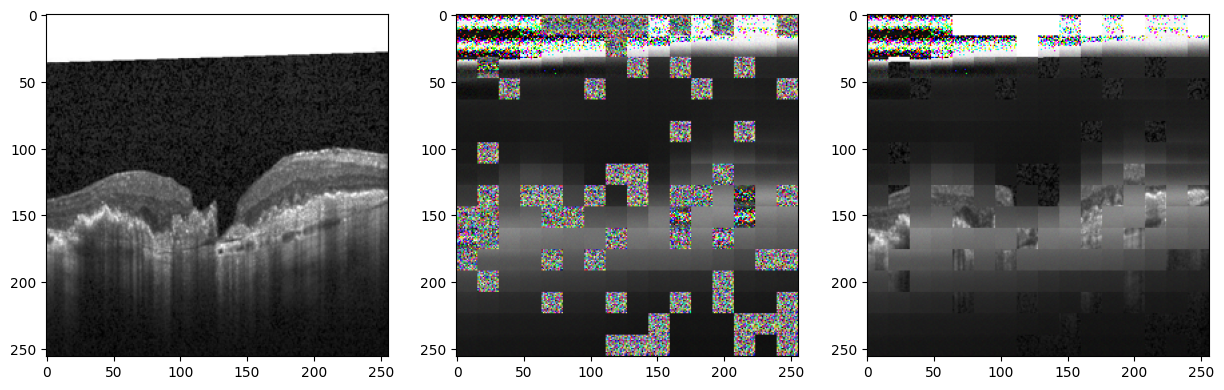

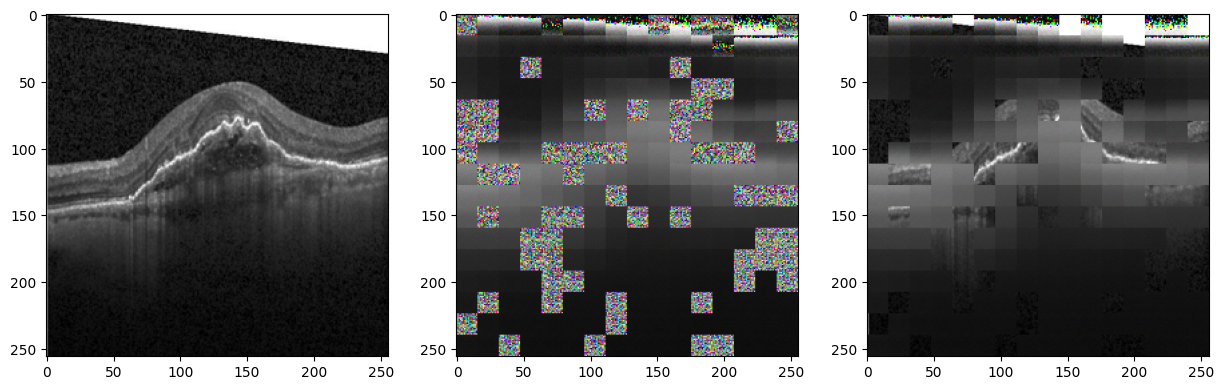

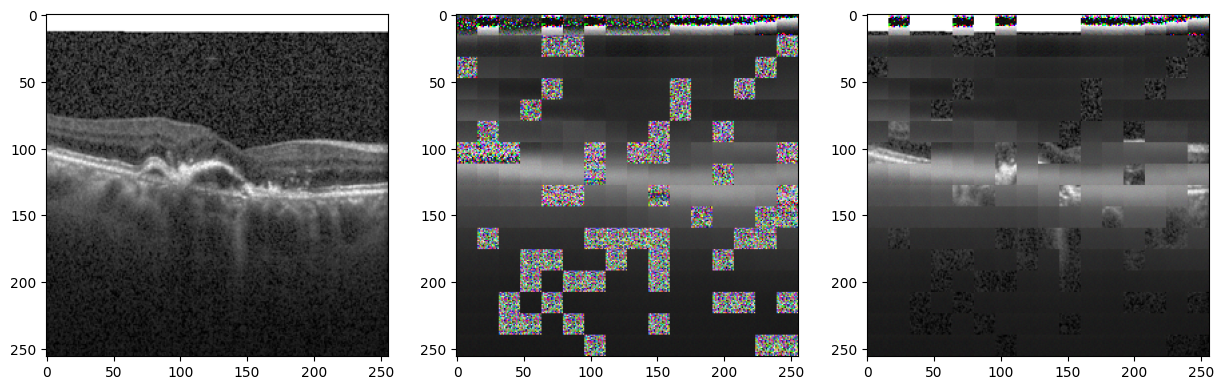

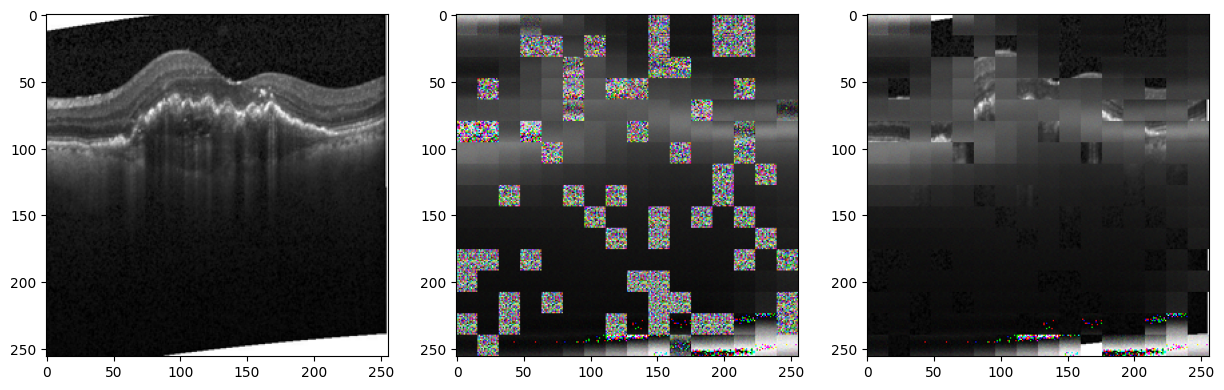

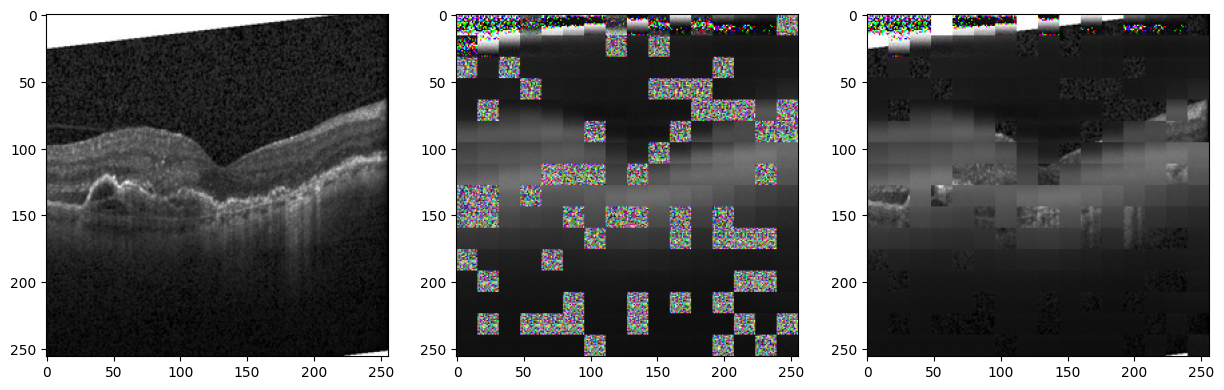

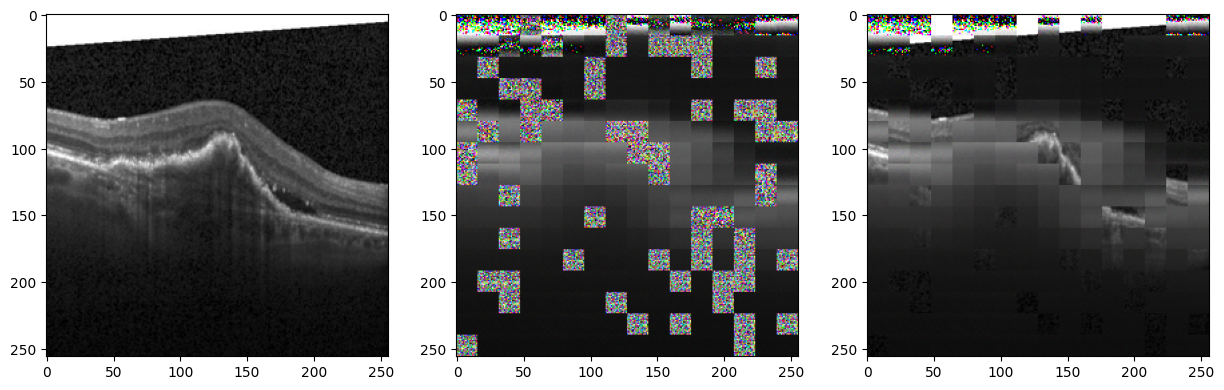

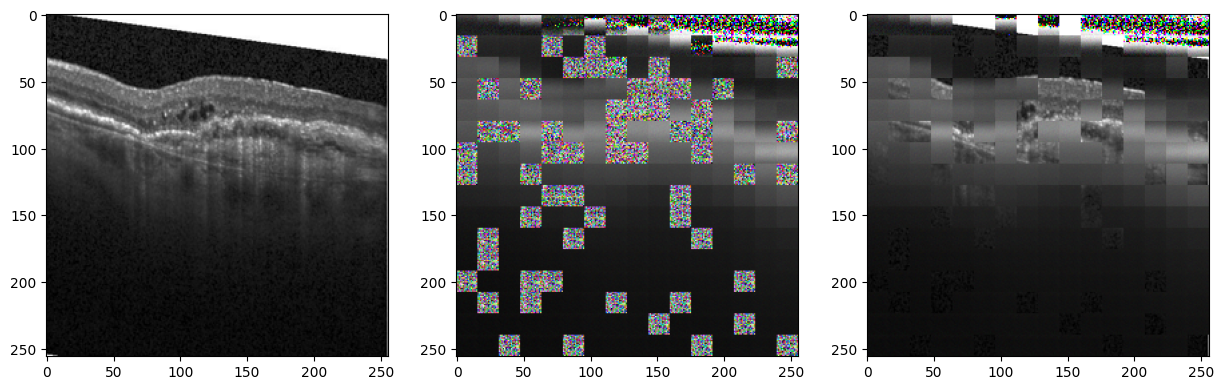

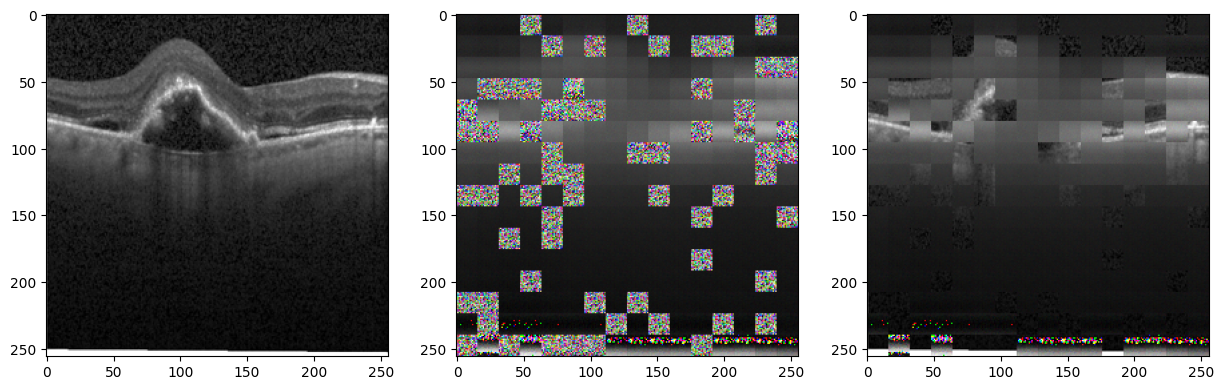

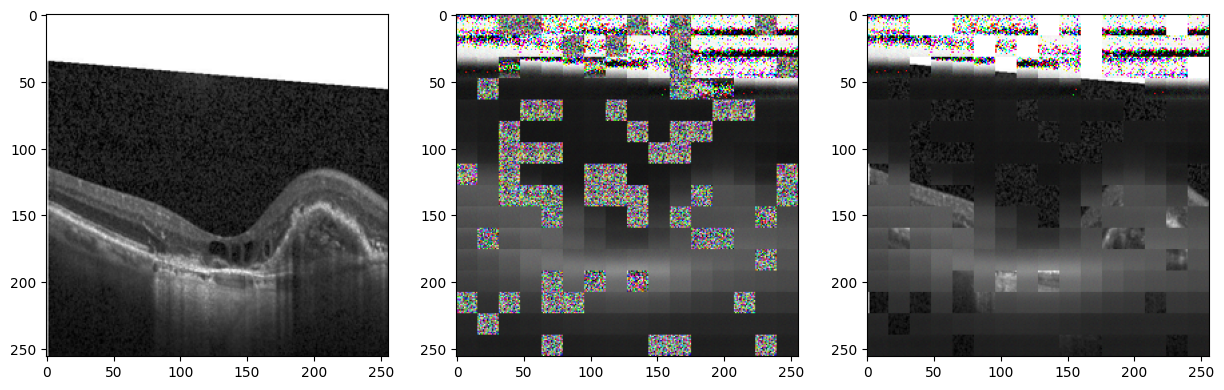

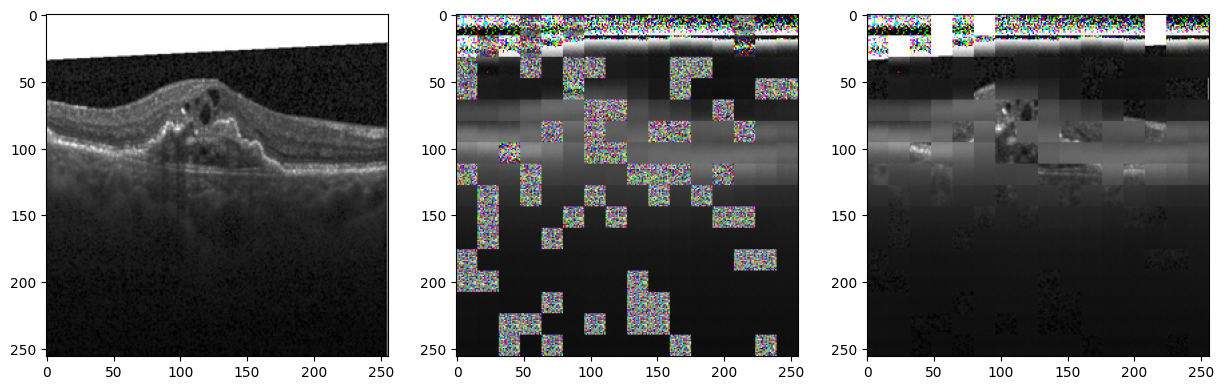

KeyboardInterrupt: 

In [42]:
for i in range(29, 59):
    # put above in (1, 3) subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(((images[0][i].cpu().detach().numpy() + 1)*127.5).astype('uint8'))
    axs[1].imshow(((images[1][i].cpu().detach().numpy() + 1)*127.5).astype('uint8'))
    axs[2].imshow(((images[2][i].cpu().detach().numpy() + 1)*127.5).astype('uint8'))
    plt.show()
    

# Splitting dataset patient wise

In [1]:
dataset_dir = '/raid/binod/prashant/eye2gene/OCT2017 '
# split images into separate folders

import os
import shutil

splits = os.listdir(dataset_dir)
classes = os.listdir(os.path.join(dataset_dir, splits[0])) # assumption: first split has all classes

In [2]:

# splitting images into separate folders, one for each patient, requires write permission on dataset
for split in splits:
    for cls in classes:
        class_dir = os.path.join(dataset_dir, split, cls)
        image_files = [file for file in os.listdir(class_dir) if file.endswith('.jpeg')] # assumption: images are in jpeg
        patients = set()
        
        for image_file in image_files:
            _, patient_id, _ = image_file.split("-")
            patients.add(patient_id)
        
        for patient_id in patients:
            patient_folder = os.path.join(class_dir, patient_id)
            save_patient_folder = os.path.join('/raid/binod/prashant/eye2gene/OCT-patientwise', split, cls, patient_id)
            os.makedirs(save_patient_folder, exist_ok=True)
            
            patient_images = [file for file in image_files if file.split("-")[1] == patient_id]
            for image in patient_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(save_patient_folder, image)
                shutil.copy(src, dst)